# **Data Visualization**

### Objectives

* Objective nr 1:
    * The client is interested in conducting a study to visually differentiate a cherry leaf that is healthy from one that contains powdery mildew.

### Inputs

Images are taken from the test, train, validation subfolders, healthy and powdery_mildew.

### Outputs

* Compute the average image size from the train set. The CNN will train on the test set; hence is fundamental that all input images have the same size. Input size determines the CNN architecture.
* Image shape embeddings are saved as pickle files.
* Plot mean and variability of images per label.
* Plot to distinguish the contrast between healthy and mildew-infected cherry leaves.
* Generate code that answers business requirement 1 and can be used to build an image montage on the Streamlit dashboard.

---

## Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import joblib
sns.set_style('white')
from matplotlib.image import imread

## Set working directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspace/mildew-detector')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/mildew-detector'

## Set input directories

Set train validation and test paths

In [5]:
my_data_dir = 'inputs/cherryleaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train' 
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available create a new version.


## Set label names

In [7]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


---

## Data visualization of image data

#### Compute average images size on train set.

In the field of computer vision, it is advisable to normalise the pixel values of images in relation to the mean and standard deviation of the dataset. This normalisation technique facilitates obtaining consistent outcomes when applying a model to new photos and can also aid in transfer learning. However, computing the mean and standard deviation can be challenging, mainly when dealing with datasets that cannot be loaded entirely into memory and have to be processed in batches.

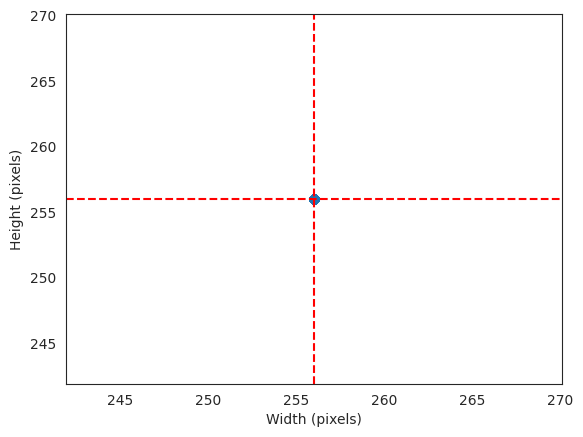

Mean width: 256px
Mean height: 256px


In [8]:
from PIL import Image

# Set the path to the train set directory
train_path = "inputs/cherryleaves_dataset/cherry-leaves/train"

# Create empty lists to store image dimensions
widths = []
heights = []

# Loop through the image files in each label directory and get their dimensions
for label in os.listdir(train_path):
    label_path = os.path.join(train_path, label)
    for image_filename in os.listdir(label_path):
        image_path = os.path.join(label_path, image_filename)
        with Image.open(image_path) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)

# Compute mean dimensions
mean_width = int(np.mean(widths))
mean_height = int(np.mean(heights))

# Create scatterplot of image dimensions
fig, ax = plt.subplots()
ax.scatter(widths, heights, alpha=0.2)
ax.axvline(x=mean_width, color='r', linestyle='--')
ax.axhline(y=mean_height, color='r', linestyle='--')
ax.set_xlabel("Width (pixels)")
ax.set_ylabel("Height (pixels)")
plt.show()

# Print mean dimensions
print(f"Mean width: {mean_width}px")
print(f"Mean height: {mean_height}px")


Images size for training the model is the average from all photos in the train set.

In [9]:
image_shape = (mean_width, mean_height, 3)
print(f"Image shape: {image_shape}")

Image shape: (256, 256, 3)


Save the image shape in a pkl file.

In [10]:
joblib.dump(value=image_shape, filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

In [11]:
from tensorflow.keras.preprocessing import image


def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            # n_images_per_label: we set a limit, since it may take too much time
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                img_resized = image.img_to_array(img)

                if img_resized.dtype != 'float32':
                    img_resized = img_resized.astype('float32')

                if img_resized.max() > 1:
                    img_resized /= 255

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y


### Load image shapes and labels in an array

In [12]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=10)
X, y = np.array(X), np.array(y)
print(X.shape, y.shape)

AttributeError: 'int' object has no attribute 'shape'

This function takes as input a set of images and their corresponding labels and plots the average image and the image variability for each unique label. The images are first subsetted based on their label, and then the mean and standard deviation are calculated for each subset. The resulting figures display the average and variability of images for each label, which can be saved as image files if desired.

In [14]:
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False, file_path=file_path) -> None:
    """
    Plots and saves the mean and standard deviation of images for each label in a dataset.

    Args:
        X (numpy.ndarray): Array of images with shape (num_samples, height, width, num_channels).
        y (numpy.ndarray): Array of labels with shape (num_samples,).
        figsize (tuple, optional): Figure size in inches. Defaults to (12, 5).
        save_image (bool, optional): Whether to save the generated plot or not. Defaults to False.
        file_path (str, optional): Path where the image will be saved. Defaults to '.'.

    Returns:
        None

    The function loops over all unique labels in y, calculates the mean and standard deviation of the images 
    belonging to each label and plots them in a figure. The figure has two subplots: one for the average 
    image and one for the standard deviation image. If save_image is True, the generated plot is saved 
    to a file in the specified file_path.
    """
    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")


==== Label healthy ====
==== Label powdery_mildew ====


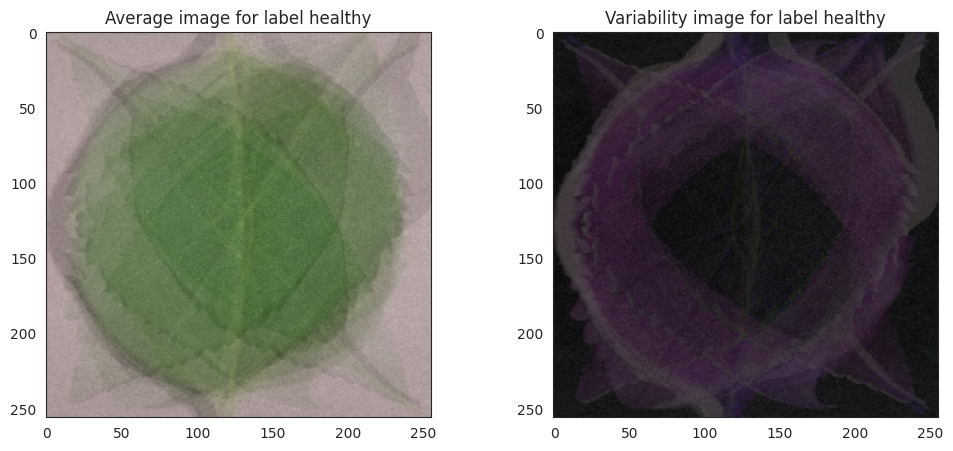

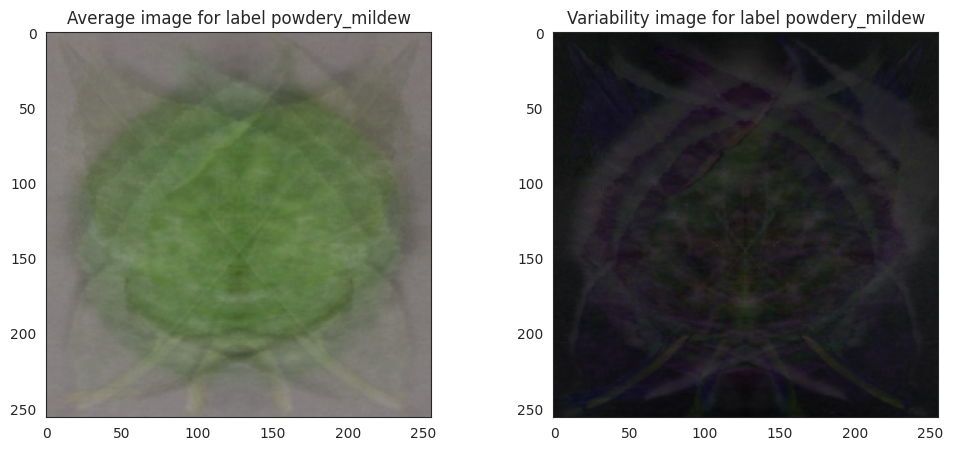

In [25]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=True)

#### The difference between the average powdery and average healthy leaves

In [35]:
def subset_image_label(X, y, label_to_display):
    """
    Filter an array of images X by a given label and return the resulting subset.

    """
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df


def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False):
    """
    Checks if the labels exist in the set of unique labels
    Calculates the mean and difference for label1 and label2
    Plots a chart and saves it if save_image=True
    """
    sns.set_style("white")

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(
            f"Either label {label} or label {label_2}, are not in {np.unique(y)} ")
        return

    # calculate mean from label1
    images_label = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label, axis=0)

    # calculate mean from label2
    images_label = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label, axis=0)

    # calculate difference and plot difference, avg label1 and avg label2
    difference_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2}')
    axes[2].imshow(difference_mean, cmap='gray')
    axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


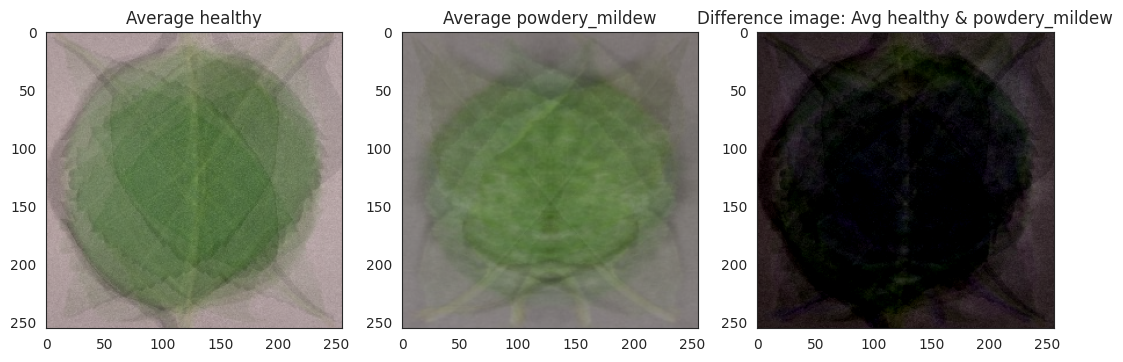

In [36]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='healthy', label_2='powdery_mildew',
                                        figsize=(13, 5),
                                        save_image=True
                                        )

---

In [37]:
import glob
import itertools

def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10), sort_order='alphabetical') -> None:
    """
    Displays a montage of images from a directory subset based on a given label.

    Args:
    - dir_path (str): The path to the directory containing the image files.
    - label_to_display (str): The label corresponding to the image subset to display.
    - nrows (int): The number of rows in the image montage.
    - ncols (int): The number of columns in the image montage.
    - figsize (tuple, optional): The size of the matplotlib figure. Default is (15, 10).
    - sort_order (str, optional): The sorting order of the image files. Options are 'alphabetical' or 'numerical'. Default is 'alphabetical'.

    Returns:
    - None
    """
    
    # Check if the label exists in the directory
    if label_to_display not in os.listdir(dir_path):
        print("The label you selected doesn't exist.")
        print(f"The existing options are: {os.listdir(dir_path)}")
        return
    
    # Load the image files in the subset directory
    img_files = glob.glob(os.path.join(dir_path, label_to_display, '*'))
    
    # Sort the image files based on the specified order
    if sort_order == 'alphabetical':
        img_files.sort()
    elif sort_order == 'numerical':
        img_files = sorted(img_files, key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))
    else:
        print("Invalid sort order. Please specify 'alphabetical' or 'numerical'.")
        return
    
    # Check if the montage space is greater than the subset size
    if nrows * ncols > len(img_files):
        print(f"Decrease nrows or ncols to create your montage. There are {len(img_files)} in your subset.")
        return
    
    # Create a list of axes indices based on nrows and ncols
    plot_idx = list(itertools.product(range(nrows), range(ncols)))
    
    # Create a Figure and display images
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        img = plt.imread(img_files[i])
        img_shape = img.shape
        ax.imshow(img)
        ax.set_title(f"Width {img_shape[1]}px x Height {img_shape[0]}px")
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()


healthy


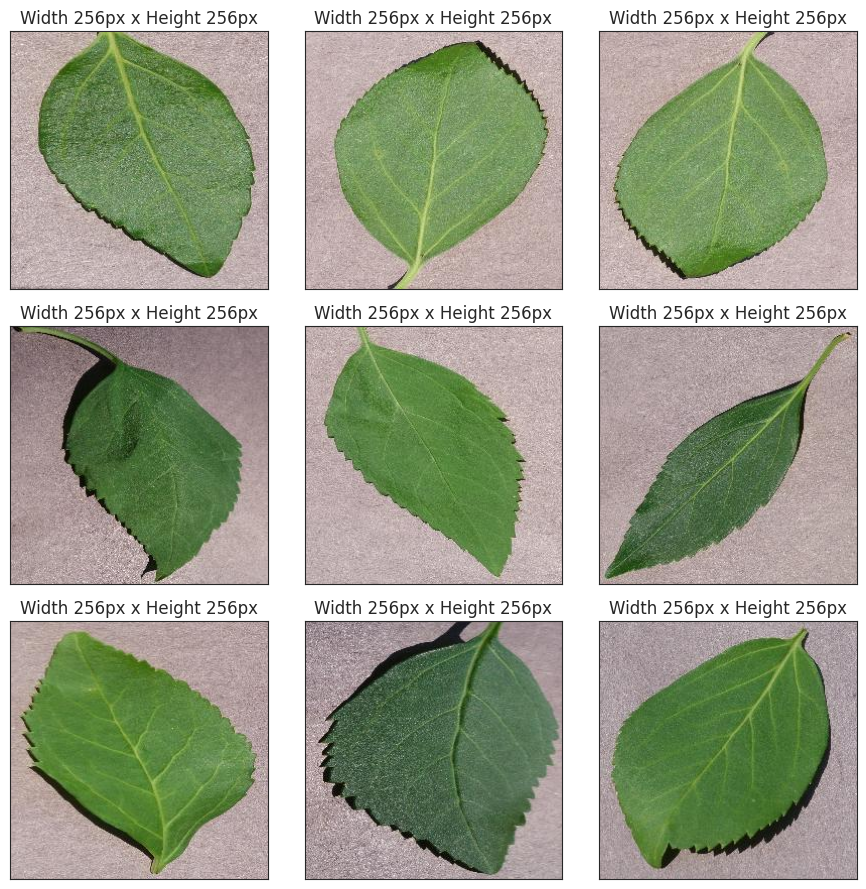



powdery_mildew


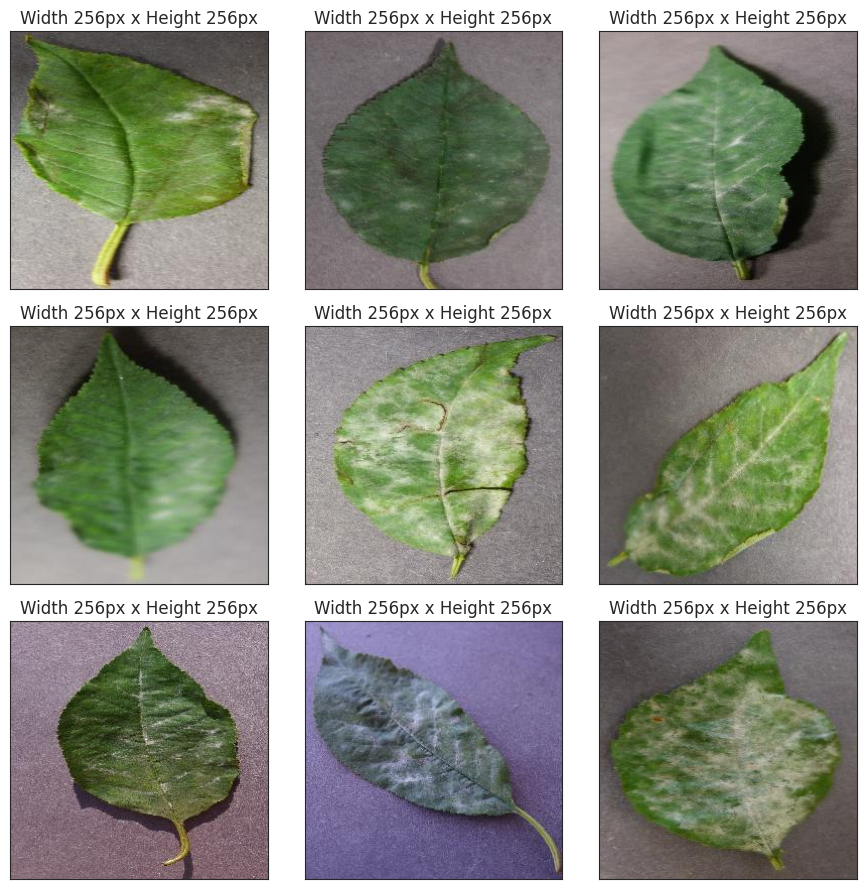

In [38]:
for label in labels:
    print(label)
    image_montage(dir_path=val_path,
                  label_to_display=label,
                  nrows=3, ncols=3,
                  figsize=(9, 9)
                  )
    print("\n")